In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import string
import itertools
import re

from wordcloud import WordCloud

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import Hinge
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

Step 1: Load data set


In [2]:
data = pd.read_csv('tweets.csv',encoding='latin', header=None)
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data.head(5)

sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [3]:
sentiment_counts = data.sentiment.value_counts()
print(sentiment_counts)

0    800000
4    800000
Name: sentiment, dtype: int64


In [4]:
text_counts = data.text.value_counts()
print(text_counts)

isPlayer Has Died! Sorry                                                                              210
good morning                                                                                          118
headache                                                                                              115
Good morning                                                                                          112
Headache                                                                                              106
                                                                                                     ... 
braces  tell me it will be okay...                                                                      1
is stuck at home without curry                                                                          1
@mrsduryee I've applied to about 70 since I lost my job in March...it certainly FEELS like a lot!       1
The cheese I got @SarawithanR lost its squeak 

In [5]:
data.describe()

sentiment            id
count  1.600000e+06  1.600000e+06
mean   2.000000e+00  1.998818e+09
std    2.000001e+00  1.935761e+08
min    0.000000e+00  1.467810e+09
25%    0.000000e+00  1.956916e+09
50%    2.000000e+00  2.002102e+09
75%    4.000000e+00  2.177059e+09
max    4.000000e+00  2.329206e+09

<AxesSubplot:>

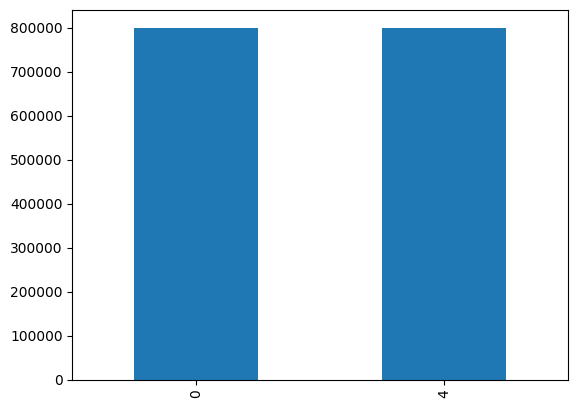

In [6]:
data['sentiment'].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='sentiment'>

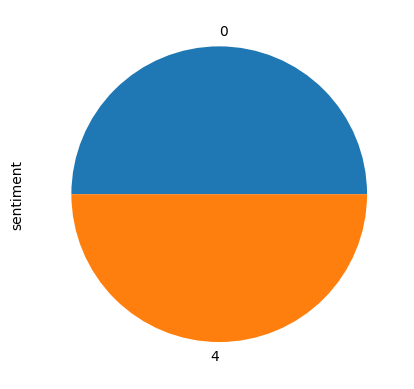

In [7]:
data['sentiment'].value_counts().plot(kind='pie')

Dropping useless info


In [8]:
data = data.drop(['id', 'date', 'query', 'user_id'], axis=1)

encoded_data = data

Assigning lable numbers with positive and neagtive traits


In [9]:
labels_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
    return labels_to_sentiment[label]
    encoded_data.sentiment = encoded_data.sentiment.apply(lambda x: label_decoder(x))
encoded_data.head(5)

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

Text(0.5, 1.0, '1.6 Million Twitter Tweets Sentiment Data Distribution')

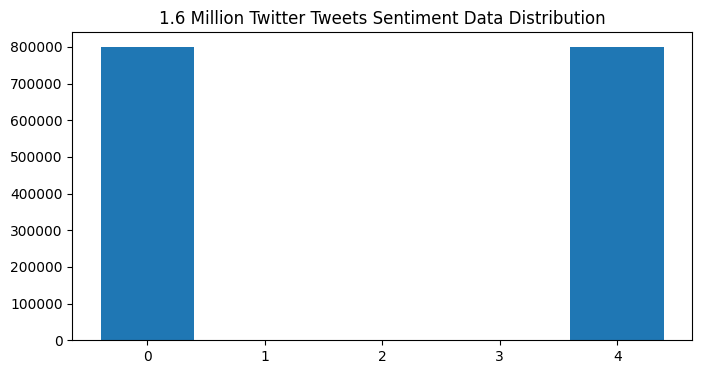

In [10]:
val_count = encoded_data.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("1.6 Million Twitter Tweets Sentiment Data Distribution")

Reducing data set


In [11]:
reduced_data = encoded_data
reduced_data.head(5)

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

Separating postive and negative rows

In [12]:
data_positive = reduced_data[reduced_data['sentiment'] == 4]
data_negative = reduced_data[reduced_data['sentiment'] == 0]
print(len(data_positive), len(data_negative))

800000 800000


In [13]:
data_positive = data_positive.iloc[:int(len(data_positive)/40)]
data_negative = data_negative.iloc[:int(len(data_negative)/40)]
print(len(data_positive), len(data_negative))

20000 20000


In [14]:
reduced_data = pd.concat([data_positive, data_negative])
len(reduced_data)

40000

In [15]:
cleaned_data = reduced_data
cleaned_data.head(5)

sentiment                                               text
800000          4       I LOVE @Health4UandPets u guys r the best!! 
800001          4  im meeting up with one of my besties tonight! ...
800002          4  @DaRealSunisaKim Thanks for the Twitter add, S...
800003          4  Being sick can be really cheap when it hurts t...
800004          4    @LovesBrooklyn2 he has that effect on everyone

Word clouds 1.Positive 2.Negative

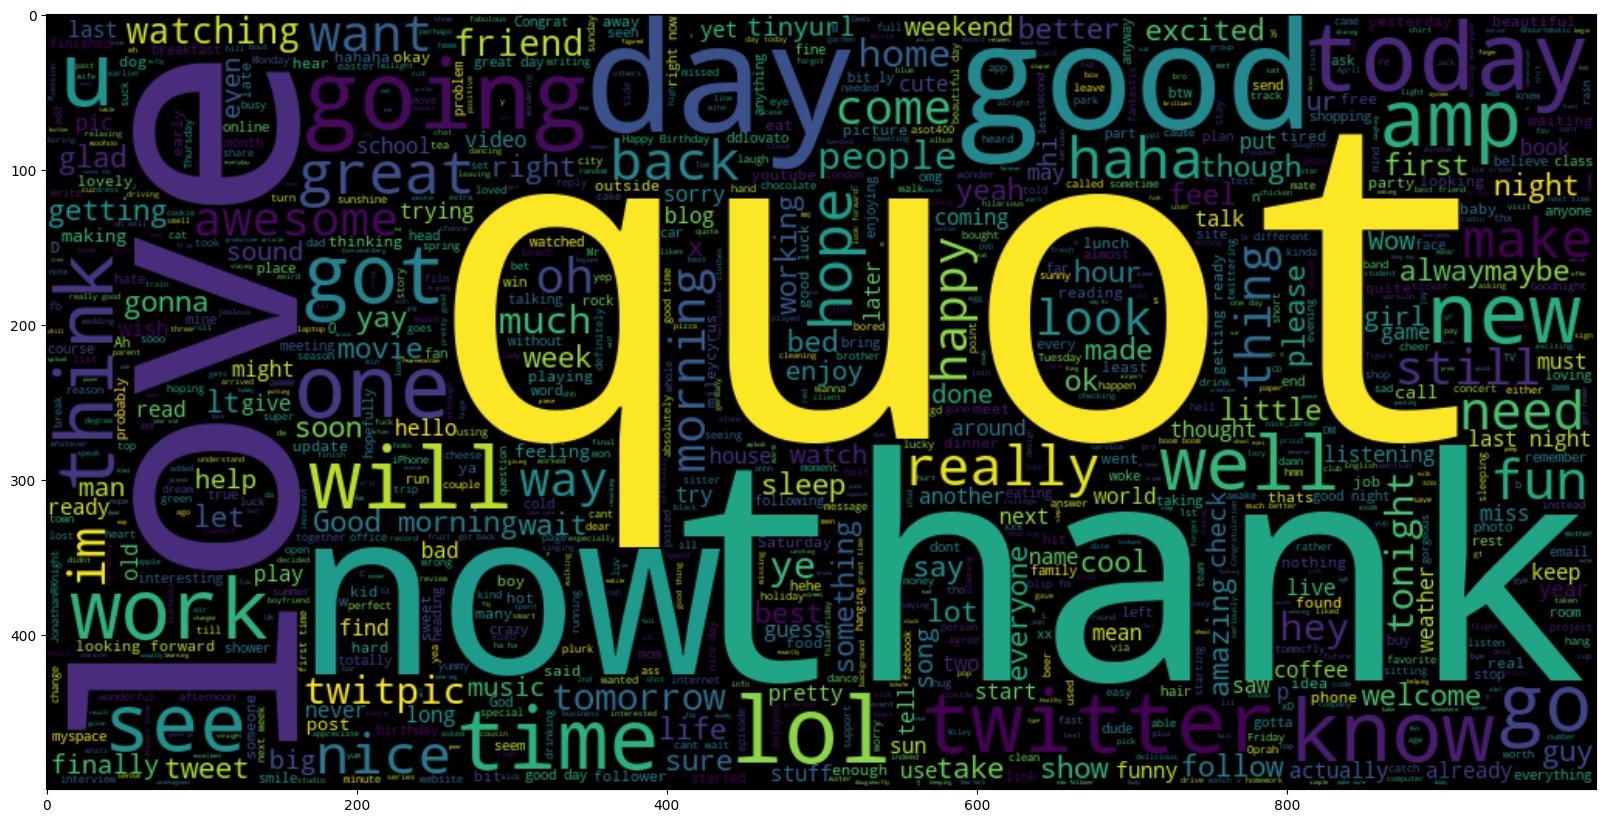

In [16]:
#Positve
plt.figure(figsize = (20,20)) 
Positive_WC = WordCloud(max_words = 1000 , width = 1000 , height = 500).generate(" ".join(cleaned_data[cleaned_data.sentiment == 4].text))
plt.imshow(Positive_WC , interpolation = 'bilinear')

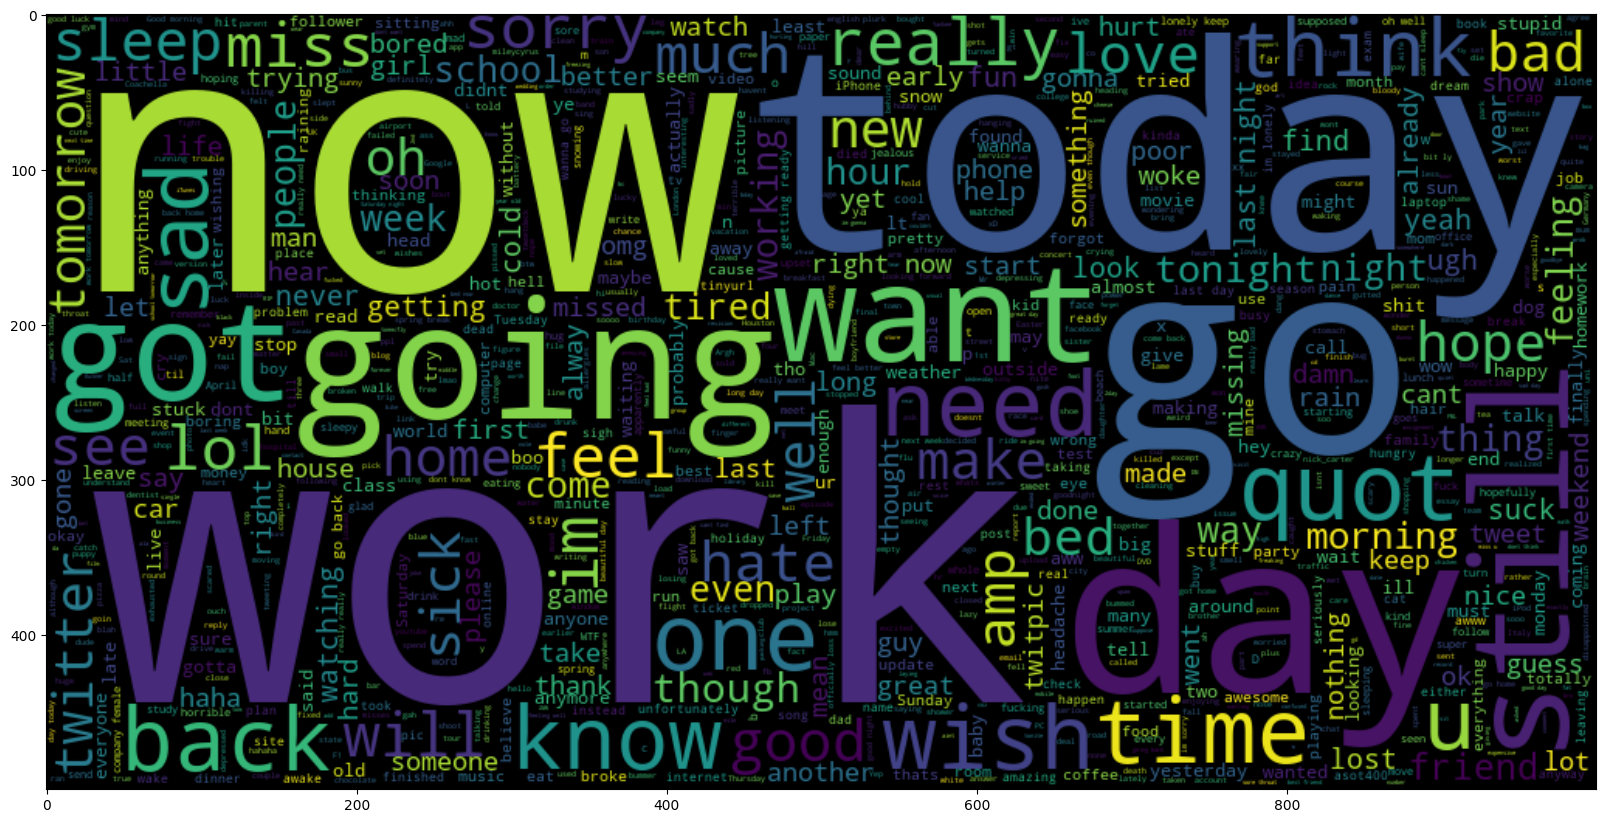

In [17]:
#Negative
plt.figure(figsize = (20,20)) 
Negative_WC = WordCloud(max_words = 1000 , width = 1000 , height = 500).generate(" ".join(cleaned_data[cleaned_data.sentiment == 0].text))
plt.imshow(Negative_WC , interpolation = 'bilinear')

Step 2: Text preprocessing

Removing URL fro the data

In [18]:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

Clearing unnecessary texts

In [19]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"    

def text_cleaning(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text

removing numbers, emojis punctuations

In [20]:
def number_cleaning(text):
    text = ''.join(c for c in text if not c.isdigit())
    return text

def remove_emoji(string):
    emoji_pattern = re.compile(
    "["
        u"\U0001F600-\U0001F64F" #emoticons
        u"\U0001F300-\U0001F5FF" #symbols & pictographs
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #FLAGS on (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_punctuation(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

Stemming the text using the porter version and removing stopwords

In [21]:
def stemming_words(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

Applying text preprocessing

In [22]:
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_URL(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_html(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: text_cleaning(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: number_cleaning(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_emoji(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_punctuation(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: stemming_words(x))
cleaned_data["text"] = cleaned_data["text"].apply(remove_stopwords)

In [23]:
cleaned_data

sentiment                                               text
800000          4                    love healthuandpet u guy r best
800001          4      im meet one besti tonight cant wait girl talk
800002          4  thank twitter add sunisa got meet onc hin show...
800003          4  sick realli cheap hurt much eat real food plu ...
800004          4                                  ha effect everyon
...           ...                                                ...
19995           0  much time thi weekend work trip malm fri sat t...
19996           0                                    one day holiday
19997           0                       feel right hate damn humprey
19998           0  geez hv read whole book person type befor emba...
19999           0  threw sign donni bent get wa thinge made sad face

[40000 rows x 2 columns]

In [24]:
cleaned_data.text

800000                      love healthuandpet u guy r best
800001        im meet one besti tonight cant wait girl talk
800002    thank twitter add sunisa got meet onc hin show...
800003    sick realli cheap hurt much eat real food plu ...
800004                                    ha effect everyon
                                ...                        
19995     much time thi weekend work trip malm fri sat t...
19996                                       one day holiday
19997                          feel right hate damn humprey
19998     geez hv read whole book person type befor emba...
19999     threw sign donni bent get wa thinge made sad face
Name: text, Length: 40000, dtype: object

Step 3: Splitting Data set

In [25]:
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=7) 

print("Train data size:", len(train_data))
print("Test data size", len(test_data))

Train data size: 32000
Test data size 8000


Step 4: Tokenization

Settings for hyper parameters

In [26]:
vocabulary_size = 100000
max_word_length = 280
oov_tk = "<OOV>"
trunc_type='post'
padding_type='post'

Tokenizing

In [27]:
tokenizer = Tokenizer(num_words = vocabulary_size, oov_token = oov_tk)
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size :", vocab_size)

Vocabulary size : 21180


Sequences

In [28]:
train_sequences = tokenizer.texts_to_sequences(train_data.text) 
test_sequences = tokenizer.texts_to_sequences(test_data.text)

Padding to handle sentences with diffrent lengths

In [29]:
x_train = pad_sequences(train_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)
x_test = pad_sequences(test_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (32000, 280)
Testing X Shape: (8000, 280)


Step 5: Label Encoding

In [30]:
labels = train_data.sentiment.unique().tolist()

In [31]:
#Encoding sentiment lables
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



y_train shape: (32000, 1)
y_test shape: (8000, 1)


Stage 6: Pretrained GloVe word embedding

loading the glove word embed

In [33]:
embeddings_index = {}

with open('./glove6b/glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [34]:
#Unique values
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21179 unique tokens.


In [35]:
embeddings_index

{'the': array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-0

Creating the embedding matrix

In [36]:
num_words = len(word_index) + 1
embedding_dimension = 300

embedding_matrix = np.zeros((vocab_size, embedding_dimension))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0073678 ,  0.062532  , -0.097432  , ..., -0.32431999,
         0.19611   ,  0.29361999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31906   , -0.32060999,  0.12637   , ...,  0.33184001,
         0.39631   , -0.16170999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Testing embedding index

In [38]:
word_index["good"]

8

In [39]:
embeddings_index.get("good")

array([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
        8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
        3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
        1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
       -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
       -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
       -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
        5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
        4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
        1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
        5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
        5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
        4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
       -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0442e-01,  1.44

In [42]:
(embedding_matrix[8] == embeddings_index.get("good")).all()

True

Analysing the training and testing data sets

In [43]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test: ",x_test.shape)
print("y_test: ",y_test.shape)

x_train: (32000, 280)
y_train: (32000, 1)
x_test:  (8000, 280)
y_test:  (8000, 1)


Step 7: Traing the 4 RNN-SVM models

Training LSTM-SVM model

In [44]:
LSTM_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.LSTM((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM((128)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [45]:
LSTM_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [46]:
print(LSTM_SVM_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 300)          6354000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 280, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 280, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 280, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

Training

In [ ]:
number_of_epochs = 10
batch_size = 256

LSTM_SVM_history = LSTM_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Plotting LSTM-SVM train graph

In [ ]:
plt.plot(LSTM_SVM_history.history['accuracy'])
plt.plot(LSTM_SVM_history.history['val_accuracy'])
plt.title('LSTM-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(LSTM_SVM_history.history['loss'])
plt.plot(LSTM_SVM_history.history['val_loss'])
plt.title('LSTM-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Saving LSTM-SVM model

In [ ]:
LSTM_SVM_model.save('saved_model/LSTM_SVM_Model')

Loading LSTM-SVM model

In [ ]:
LSTM_SVM_saved_model = tf.keras.models.load_model('saved_model/LSTM_SVM_Model')

Training Bidirectional LSTM-SVM model

In [47]:
BILSTM_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(128), return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(128))),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [48]:
BILSTM_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [49]:
print(BILSTM_SVM_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 300)          6354000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 280, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 280, 256)         439296    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 280, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                      

Training

In [ ]:
number_of_epochs = 10
batch_size = 256

BILSTM_SVM_history = BILSTM_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Plotting Bidirectional LSTM-SVM train graph

In [ ]:
plt.plot(BILSTM_SVM_history.history['accuracy'])
plt.plot(BILSTM_SVM_history.history['val_accuracy'])
plt.title('BILSTM-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(BILSTM_SVM_history.history['loss'])
plt.plot(BILSTM_SVM_history.history['val_loss'])
plt.title('BILSTM-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Saving Birectional LSTM-SVM model

In [ ]:
BILSTM_SVM_model.save('saved_model/BILSTM_SVM_Model')

Loading Birectional LSTM-SVM model

In [ ]:
BILSTM_SVM_saved_model = tf.keras.models.load_model('saved_model/BILSTM_SVM_Model')

Training the GRU-SVM model

In [51]:
GRU_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.GRU((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.GRU((128)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [52]:
GRU_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [53]:
print(GRU_SVM_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 280, 300)          6354000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 280, 300)         0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 280, 128)          165120    
                                                                 
 dropout_4 (Dropout)         (None, 280, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

Training

In [ ]:
number_of_epochs = 10
batch_size = 256

GRU_SVM_history = GRU_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Plotting GRU-SVM train graph

In [ ]:
plt.plot(GRU_SVM_history.history['accuracy'])
plt.plot(GRU_SVM_history.history['val_accuracy'])
plt.title('GRU-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(GRU_SVM_history.history['loss'])
plt.plot(GRU_SVM_history.history['val_loss'])
plt.title('GRU-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Saving GRU-SVM model

Loading GRU-SVM model

Training Bidirectional GRU-SVM model

In [54]:
BIGRU_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.GRUCell(128), return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.GRUCell(128))),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [55]:
BIGRU_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [56]:
print(BIGRU_SVM_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 280, 300)          6354000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 280, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 280, 256)         330240    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 280, 256)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                      

Training

In [ ]:
number_of_epochs = 10
batch_size = 256

BIGRU_SVM_history = BIGRU_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Plotting Bidirectional GRU-SVM train graph

In [ ]:
plt.plot(BIGRU_SVM_history.history['accuracy'])
plt.plot(BIGRU_SVM_history.history['val_accuracy'])
plt.title('BIGRU-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(BIGRU_SVM_history.history['loss'])
plt.plot(BIGRU_SVM_history.history['val_loss'])
plt.title('BIGRU-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Saving Bidirectional GRU-SVM model

In [ ]:
BIGRU_SVM_model.save('saved_model/BIGRU_SVM_Model')

Loading Bidirectional GRU-SVM model

In [ ]:
BIGRU_SVM_saved_model = tf.keras.models.load_model('saved_model/BIGRU_SVM_Model')

Step 8: Accuracy Analysis

Test Acuracy and Loss

In [ ]:
test_loss, test_acc = LSTM_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Testing hybrid model against the testing dataset

In [ ]:
LSTM_SVM_scores = LSTM_SVM_model.predict(x_test, verbose=1, batch_size=256)

In [ ]:
LSTM_SVM_scores

In [ ]:
LSTM_SVM_y_pred=np.where(LSTM_SVM_scores>0.5,1,0)

In [ ]:
LSTM_SVM_y_pred

Accuracy

In [ ]:
print(accuracy_score(y_test, LSTM_SVM_y_pred))

Classification report (Precision, Recall, F1-Score and Accuracy)

In [ ]:
print(classification_report(y_test, LSTM_SVM_y_pred))

Confusion Matrix

In [ ]:
LSTM_SVM_CM=confusion_matrix(y_test, LSTM_SVM_y_pred)
print(LSTM_SVM_CM)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
categories = ['Negative','Positive']
LSTM_SVM_cnf_matrix = confusion_matrix(y_test, LSTM_SVM_y_pred)
plot_confusion_matrix(cm=LSTM_SVM_cnf_matrix, classes=categories, title='LSTM-SVM Confusion Matrix')
plt.show()

Bidirectional LSTM-SVM Accuracy Analysis

Test accuracy and loss

In [ ]:
test_loss, test_acc = BILSTM_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Testing the hybrid model against the testing data set

In [ ]:
BILSTM_SVM_scores = BILSTM_SVM_model.predict(x_test, verbose=1, batch_size=256)

In [ ]:
BILSTM_SVM_scores

In [ ]:
BILSTM_SVM_y_pred=np.where(BILSTM_SVM_scores>0.5,1,0)

In [ ]:
BILSTM_SVM_y_pred

In [ ]:
print(accuracy_score(y_test, BILSTM_SVM_y_pred))

Classification report (Precision, Recall, F1-Score and Accuracy)

In [ ]:
print(classification_report(y_test, BILSTM_SVM_y_pred))

Confusion Matrix

In [ ]:
BILSTM_SVM_CM=confusion_matrix(y_test, BILSTM_SVM_y_pred)
print(BILSTM_SVM_CM)

In [ ]:
categories = ['Negative','Positive']
BILSTM_SVM_cnf_matrix = confusion_matrix(y_test, BILSTM_SVM_y_pred)
plot_confusion_matrix(cm=BILSTM_SVM_cnf_matrix, classes=categories, title='BILSTM-SVM Confusion Matrix')
plt.show()

GRU-SVM accuracy analysis

Test accuracy and loss

In [ ]:
test_loss, test_acc = GRU_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Testing the hybrid model against the testing data set

In [ ]:
GRU_SVM_scores = GRU_SVM_model.predict(x_test, verbose=1, batch_size=256)

In [ ]:
GRU_SVM_scores

In [ ]:
GRU_SVM_y_pred=np.where(GRU_SVM_scores>0.5,1,0)

In [ ]:
GRU_SVM_y_pred

Accuracy

In [ ]:
print(accuracy_score(y_test, GRU_SVM_y_pred))

Classification report (Precision, Recall, F1-Score and Accuracy)

In [ ]:
print(classification_report(y_test, GRU_SVM_y_pred))

Confusion matrix

In [ ]:
GRU_SVM_CM=confusion_matrix(y_test, GRU_SVM_y_pred)
print(GRU_SVM_CM)

In [ ]:
categories = ['Negative','Positive']
GRU_SVM_cnf_matrix = confusion_matrix(y_test, GRU_SVM_y_pred)
plot_confusion_matrix(cm=GRU_SVM_cnf_matrix, classes=categories, title='GRU-SVM Confusion Matrix')
plt.show()

Bidirectional GRU-SVM Accuracy Analysis

Test accuracy and loss

In [ ]:
test_loss, test_acc = BIGRU_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Testing the hybrid model against the testing data set

In [ ]:
BIGRU_SVM_scores = BIGRU_SVM_model.predict(x_test, verbose=1, batch_size=256)

In [ ]:
BIGRU_SVM_scores

In [ ]:
BIGRU_SVM_y_pred=np.where(BIGRU_SVM_scores>0.5,1,0)

In [ ]:
BIGRU_SVM_y_pred

Accuracy

In [ ]:
print(accuracy_score(y_test, BIGRU_SVM_y_pred))

Classification report (Precision, Recall, F1-Score and Accuracy)

In [ ]:
print(classification_report(y_test, BIGRU_SVM_y_pred))

Confusion Matrix

In [ ]:
BIGRU_SVM_CM=confusion_matrix(y_test, BIGRU_SVM_y_pred)
print(BIGRU_SVM_CM)

In [ ]:
categories = ['Negative','Positive']
BIGRU_SVM_cnf_matrix = confusion_matrix(y_test, BIGRU_SVM_y_pred)
plot_confusion_matrix(cm=BIGRU_SVM_cnf_matrix, classes=categories, title='BIGRU-SVM Confusion Matrix')
plt.show()

Step 9: Testing Area

1 - Postitve tweet
2 - Negative Tweet
3 - Sarcastic Tweet
4 - Neutral Tweet
5 - Scary Joke tweet

LSTM-SVM testing class

In [ ]:
test_sentence1 = [ "The flight was amazing #POG. I will fly again because it was exquisite and the bathtub was ok :)", 
                  "This REEESUBHUMAN political party are absolutely horrible, racist, dumb and rude >:(", 
                  "Hope they get nuked. such an uncvis.ised uvu twats booooooo you stink lol XD", 
                  "This game called Destiny it's alright, it provides decent loot and ok rewards. I will play it again with my friends", 
                  "Bruh, Imma SSJ3 kamehameha those dementors from Harry Potter because they are scary. "]


#Converting the sentences to sequences using a tokenizer
test_sequences1 = tokenizer.texts_to_sequences(test_sentence1)

#Padding the new sequences to make them have the same dimension
test_padded1 = pad_sequences(test_sequences1, maxlen = max_word_length, 
                             padding = padding_type, truncating = trunc_type)

#Testing out the new padded data on a trained LSTM-SVM model
test_padded1 = np.array(test_padded1)
print(LSTM_SVM_model.predict(test_padded1))

Bidirectional LSTM-SVM Testing Class

In [ ]:
test_sentence2 = [ "The flight was amazing #POG. I will fly again because it was exquisite and the bathtub was ok :)", 
                  "This REEESUBHUMAN political party are absolutely horrible, racist, dumb and rude >:(", 
                  "Hope they get nuked. such an uncvis.ised uvu twats booooooo you stink lol XD", 
                  "This game called Destiny it's alright, it provides decent loot and ok rewards. I will play it again with my friends", 
                  "Bruh, Imma SSJ3 kamehameha those dementors from Harry Potter because they are scary. "]


#Converting the sentences to sequences using tokenizer
test_sequences2 = tokenizer.texts_to_sequences(test_sentence2)

#Padding the new sequences to make them have same dimensions
test_padded2 = pad_sequences(test_sequences2, maxlen = max_word_length, 
                             padding = padding_type, truncating = trunc_type)

#Testing out the new padded data on a trained Bidirectional LSTM-SVM model
test_padded2 = np.array(test_padded2)
print(BILSTM_SVM_model.predict(test_padded2))

GRU-SVM Testing Class

In [ ]:
test_sentence3 = [ "The flight was amazing #POG. I will fly again because it was exquisite and the bathtub was ok :)", 
                  "This REEESUBHUMAN political party are absolutely horrible, racist, dumb and rude >:(", 
                  "Hope they get nuked. such an uncvis.ised uvu twats booooooo you stink lol XD", 
                  "This game called Destiny it's alright, it provides decent loot and ok rewards. I will play it again with my friends", 
                  "Bruh, Imma SSJ3 kamehameha those dementors from Harry Potter because they are scary."]


# Converting the sentences to sequences using tokenizer
test_sequences3 = tokenizer.texts_to_sequences(test_sentence3)

# padding the new sequences to make them have same dimensions
test_padded3 = pad_sequences(test_sequences3, maxlen = max_word_length, 
                             padding = padding_type, truncating = trunc_type)

#Testing out the new padded data on a trained GRU-SVM model
test_padded3 = np.array(test_padded3)
print(GRU_SVM_model.predict(test_padded3))

Bidirectional GRU-SVM Testing Class

In [ ]:
test_sentence4 = [ "The flight was amazing #POG. I will fly again because it was exquisite and the bathtub was ok :)", 
                  "This REEESUBHUMAN political party are absolutely horrible, racist, dumb and rude >:(", 
                  "Hope they get nuked. such an uncvis.ised uvu twats booooooo you stink lol XD", 
                  "This game called Destiny it's alright, it provides decent loot and ok rewards. I will play it again with my friends", 
                  "Bruh, Imma SSJ3 kamehameha those dementors from Harry Potter because they are scary."]


# Converting the sentences to sequences using tokenizer
test_sequences4 = tokenizer.texts_to_sequences(test_sentence4)

# padding the new sequences to make them have same dimensions
test_padded4 = pad_sequences(test_sequences4, maxlen = max_word_length, 
                             padding = padding_type, truncating = trunc_type)

#Testing out the new padded data on a trained BIGRU-SVM model
test_padded4 = np.array(test_padded4)
print(BIGRU_SVM_model.predict(test_padded4))

Conclusion

The Bidirectional GRU-SVM model is the best model to use to detect human emotion in Twitter text tweets. This model can understand positive, negative, neutral, and sarcastic sentences but fails to understand a scary joke sentence compared to the Bidirectional LSTM-SVM model which is able to detect only neutral and the negative sentences. This is possible because the Bidirectional GRU-SVM model GRU model has 2 gates which are the update and reset gate compared to the Bidirectional LSTM-SVM model LSTM model which has 3 gates and they are the input, forget and output gates. This simplicity is the GRU main benefit combined with the SVM optimal hyperplanes which is designed for the separation of training data without errors and soft margins which allows for an analytic treatment of learning with errors on the training set compared to the LSTM model which are complex with 3 gates.